In [41]:
## import necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import pandas as pd
from sklearn.cluster import KMeans


In [2]:
# get name of images
import os
jpg_files = []
for root, dirs, files in os.walk("."):
    for filename in files:
        if "jpg" in filename:
            jpg_files.append(filename)

In [3]:
def ICV_LBP(image,window_length,window_width,border_case,plot):
    
    # to store lbp of image
    lbp_full_image = np.zeros(image.shape)
    
    # this will implement border_case == 'ignore_boreder' by starting and ending for loop accordingly
    ignore_int = 0
    
    # new image created for implementing different border halding methods
    new_image = np.zeros((image.shape[0]+2,image.shape[1]+2))
    new_image[1:image.shape[0]+1,1:image.shape[1]+1] = image.copy()
    
    # we have to take care of borders. We can either put zeros or take mirror image.
    # 3 cases of how to deal with borders
    if border_case == 'ignore_border':
        ignore_int = 1
        
    if border_case == 'mirror':
        # pad image with first and last row and columns
        new_image[0,1:image.shape[1]+1] = image[0,:]
        new_image[-1,1:image.shape[1]+1] = image[-1,:]
        new_image[1:image.shape[0]+1,0] = image[:,0]
        new_image[1:image.shape[0]+1,-1] = image[:,-1]
        
    if border_case == 'zeros':
        # pad image with first and last row and columns
        # already padded with zeros
        ignore_int = 0
    
    # consider a single window in every iteration of i,j loop
    for i in range(1,1+image.shape[0],window_width):
        for j in range(1,1+image.shape[1],window_length):
            
            # to store local binary descriptor for each pixel
            lbp_freq = np.zeros((256))
            # working on window in k,l loop
            for k in range(i+ignore_int,min(i+window_width,image.shape[0])-ignore_int):
                for l in range(j+ignore_int,min(j+window_length,image.shape[1])-ignore_int):
                    
                    # get bits and convert to decimal
                    bit_1 = new_image[k-1,l-1] > new_image[k,l]
                    bit_2 = new_image[k-1,l] > new_image[k,l]
                    bit_3 = new_image[k-1,l+1]>new_image[k,l]
                    bit_4 = new_image[k,l+1] > new_image[k,l]
                    bit_5 = new_image[k+1,l+1] > new_image[k,l]
                    bit_6 = new_image[k+1,l]> new_image[k,l]
                    bit_7 = new_image[k+1,l-1]> new_image[k,l]
                    bit_8 = new_image[k,l-1]> new_image[k,l]

                    decimal_number = bit_1*np.power(2,7) + bit_2*np.power(2,6) + bit_3*np.power(2,5)+ bit_4*np.power(2,4)+ bit_5*np.power(2,3)+ bit_6*np.power(2,2)+ bit_7*np.power(2,1)+ bit_8*np.power(2,0)
                    
                    # store lbp value for classification and printing later
                    lbp_full_image[k-1,l-1] = decimal_number
                    
                    lbp_freq[decimal_number] = lbp_freq[decimal_number] + 1
            
            
            if(plot == True):
                # window image
                figure(figsize=(10, 10))
                sidx_x = i+ignore_int-1
                sidx_y = j+ignore_int-1
                eidx_x = min(i+window_width,image.shape[0])-ignore_int -1
                eidx_y = min(j+window_length,image.shape[1])-ignore_int - 1
                plt.imshow(image[sidx_x:eidx_x,sidx_y:eidx_y],cmap='gray')
                plt.title("image window for row and columns, "+str(i-1)+" , "+str(j-1))
                plt.show()

                # lbp of window image
                figure(figsize=(10, 10))
                sidx_x = i+ignore_int-1
                sidx_y = j+ignore_int-1
                eidx_x = min(i+window_width,image.shape[0])-ignore_int -1
                eidx_y = min(j+window_length,image.shape[1])-ignore_int - 1
                plt.imshow(lbp_full_image[sidx_x:eidx_x,sidx_y:eidx_y],cmap='gray')
                plt.title("LBP for window row and columns, "+str(i-1)+" , "+str(j-1))
                plt.show()

                # normalize histogram
                lbp_freq = lbp_freq/np.sum(lbp_freq)
                # use pyplot.bar to make histogram
                fig = plt.figure(figsize=(10, 10), dpi=80)
                plt.bar(np.arange(lbp_freq.shape[0]),lbp_freq)
                plt.xlabel("LBP number in decimal")
                plt.ylabel("Number of pixels in bin")
                plt.title("LBP histogram for window row and columns, "+str(i-1)+" , "+str(j-1))
                plt.show()
            
    return lbp_full_image

            
            

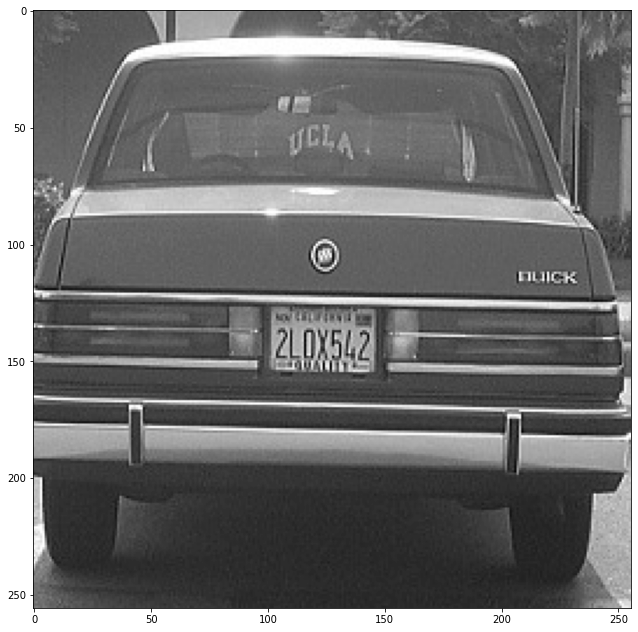

In [4]:
figure(figsize=(14, 11))
img = cv2.imread('DatasetA/'+jpg_files[5])
# as opencv loads in BGR format by default, we want to show it in RGB.
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')
plt.show()

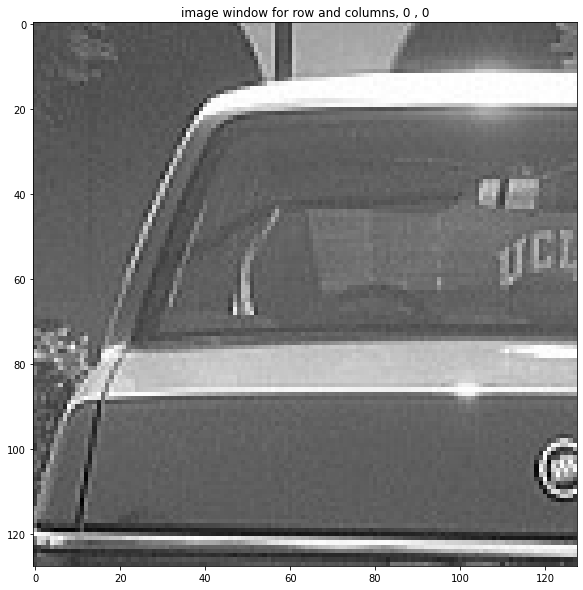

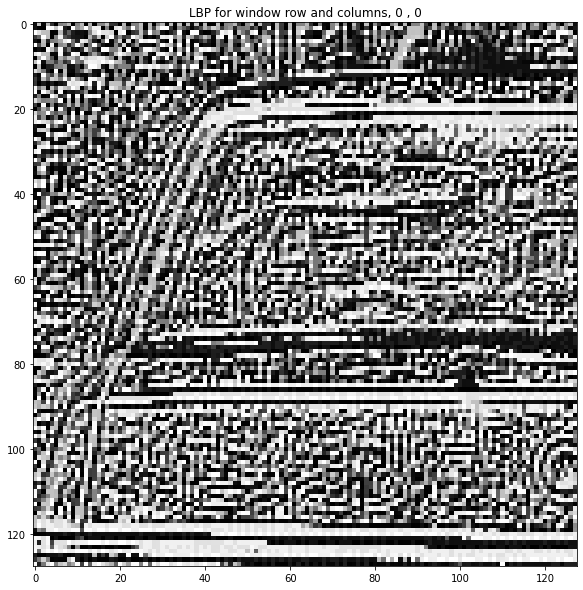

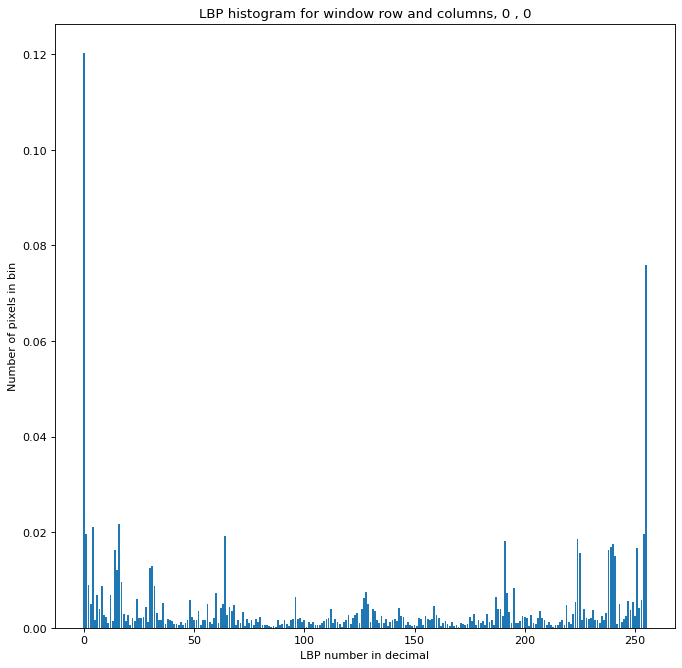

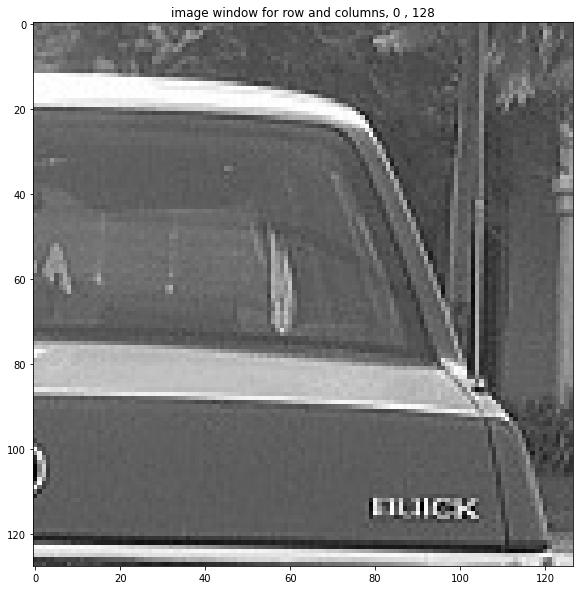

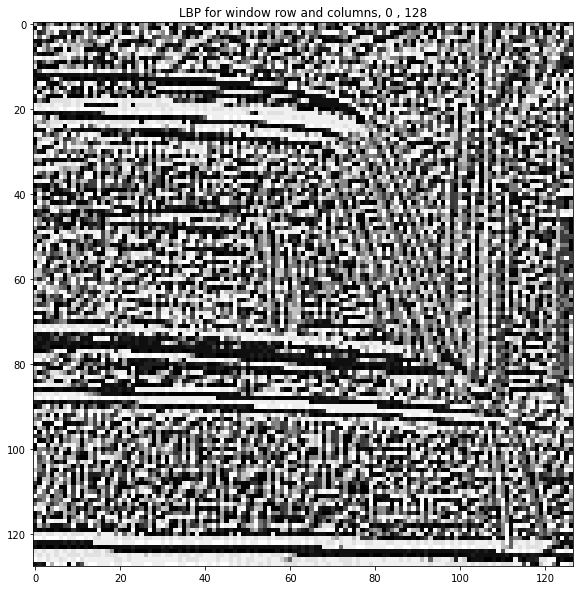

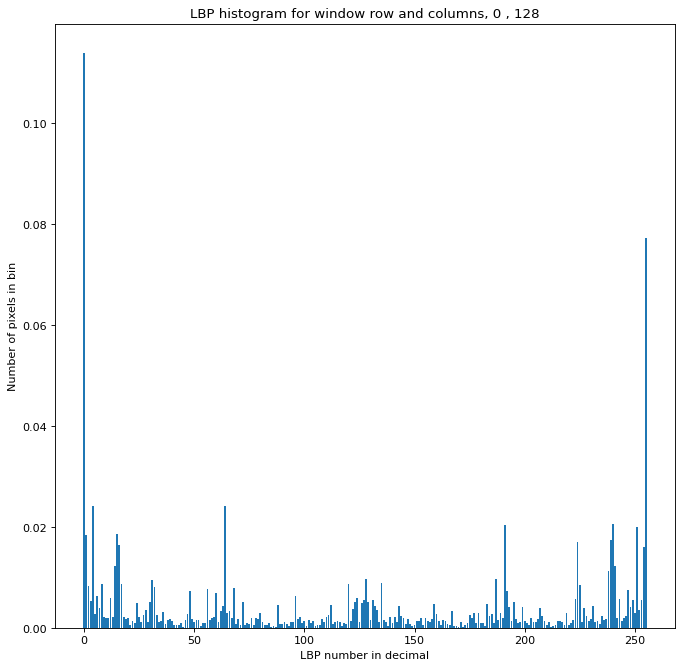

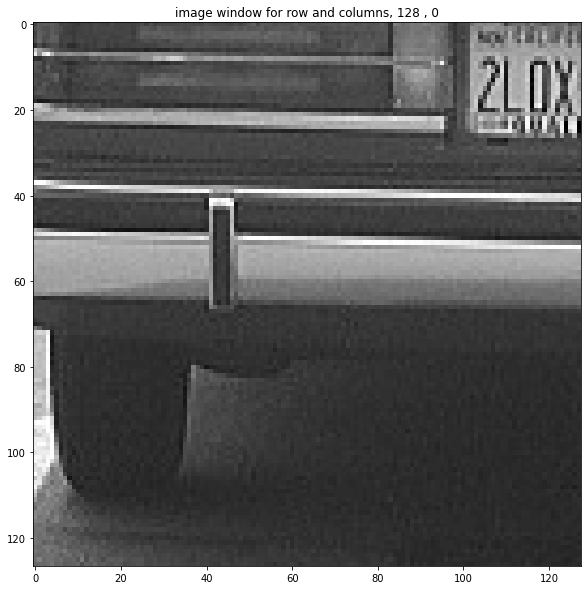

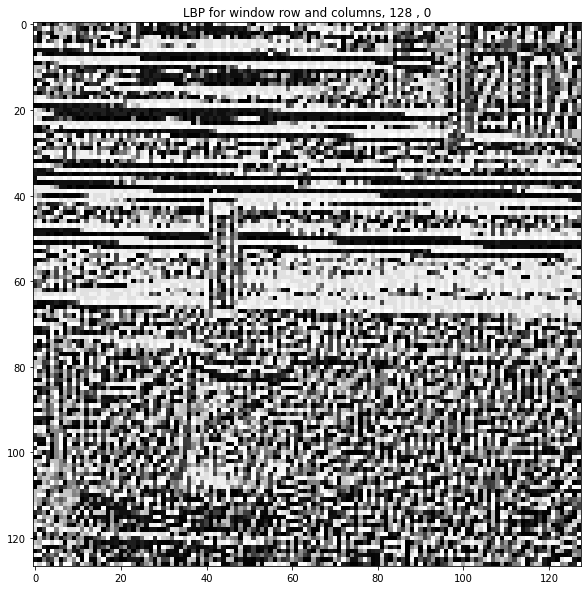

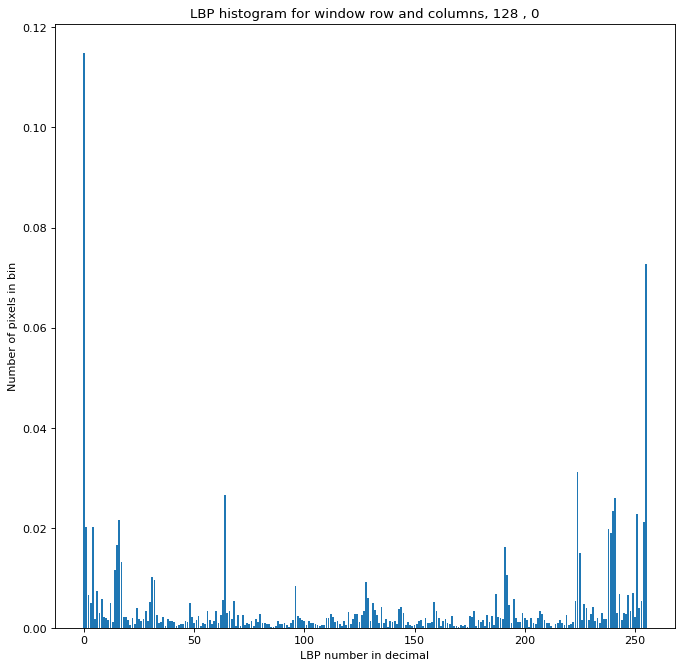

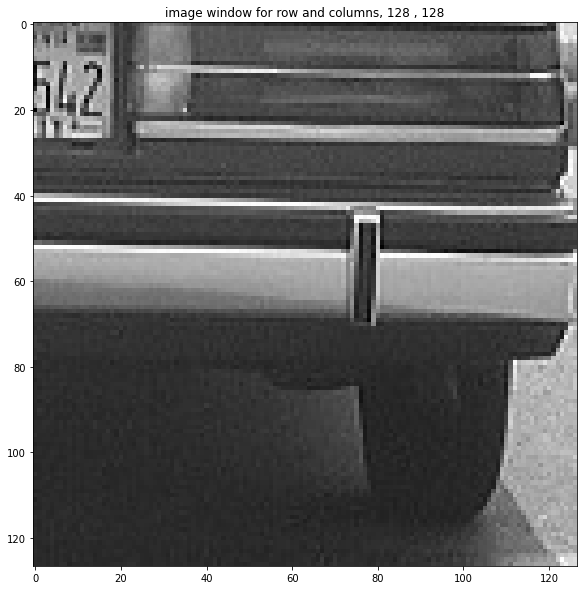

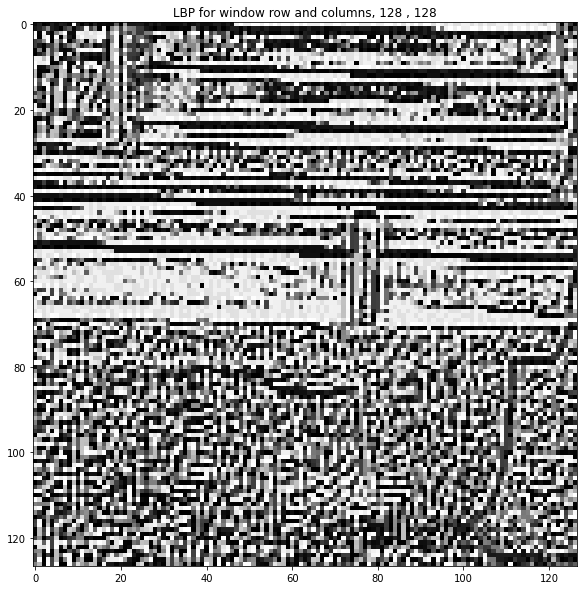

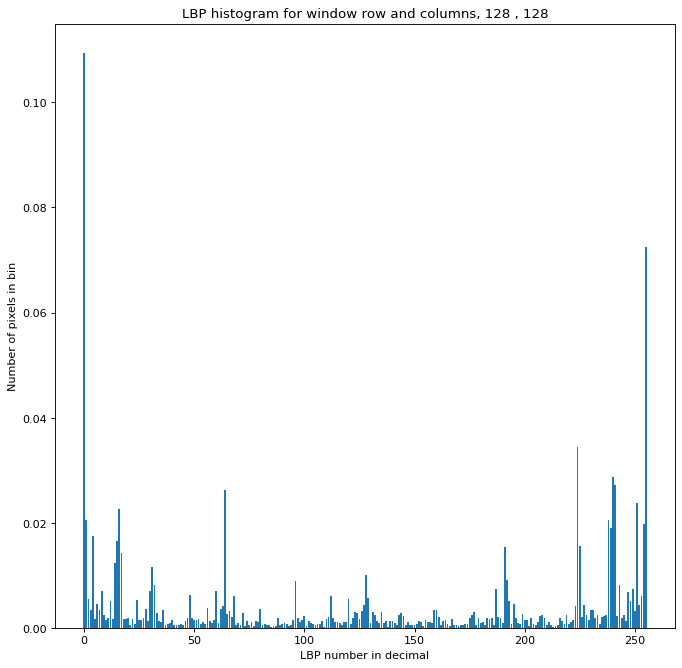

In [7]:
lbp_full_image = ICV_LBP(img,128,128,"mirror",True)

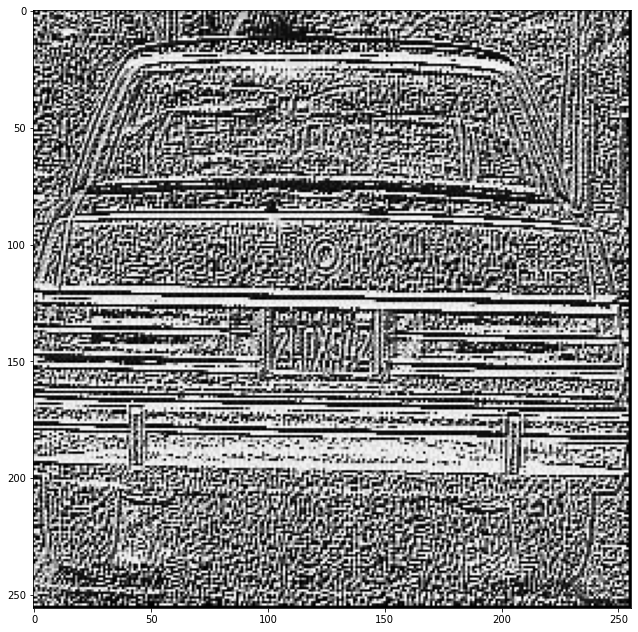

In [8]:
# lbp of full image
figure(figsize=(14, 11))
plt.imshow(lbp_full_image,cmap='gray')
plt.show()

### Part B

In [52]:
# returns an array of lbps of all windows in an image ( a global descriptor)
def ICV_lbp_descriptor(image,window_length,window_width):
    
    # create the full image lbp using mirror adjustment. for borders
    lbp_full_image = ICV_LBP(image,window_length,window_width,"mirror",False)
    
    # to store reshaped lbp of every window
    window_lbps = []
    # loop through the full image lbp
    for i in range(0,image.shape[0],window_width):
        for j in range(0,image.shape[1],window_length):
            
            # get lbp of window and store it
            lbp_window = lbp_full_image[i:i+window_width,j:j+window_length]
            window_lbps.append(lbp_window.reshape(-1,1))
            
    return np.squeeze(np.array(window_lbps))

In [53]:
# loop through each image and get global lbp descriptors
def ICV_global_descriptor(filenames,window_length,window_width):
    global_lbp_descriptors = []
    for i in range(len(filenames)):
        print("working on image ",i)
        img = cv2.imread('DatasetA/'+filenames[i])
        # as opencv loads in BGR format by default, we want to show it in RGB.
        img = cv2. cvtColor(img, cv2.COLOR_BGR2GRAY)
        window_lbps = ICV_lbp_descriptor(img,window_length,window_width)
        global_lbp_descriptors.append(window_lbps)
    return global_lbp_descriptors

In [55]:
global_lbp_descriptors = ICV_global_descriptor(jpg_files,128,128)

working on image  0
working on image  1
working on image  2
working on image  3
working on image  4
working on image  5


##### Classification 

In [50]:
# Given the global descriptors array,(array of global descriptors of all images) perform classification on them
def ICV_lbp_classify(global_lbp_descriptors,filenames):
    
    # find out count of lbp for each window in every image. This will help in calculating histogram similarity
    lbp_count_all_image = []
    for i in range(len(global_lbp_descriptors)):
        lbp_count_image = np.zeros((global_lbp_descriptors[i].shape[0],256))
        for j in range(global_lbp_descriptors[i].shape[0]):
            temp_descriptor = global_lbp_descriptors[i][j,:]
            for k in range(temp_descriptor.shape[0]):
                lbp_count_image[j,int(temp_descriptor[k])] = lbp_count_image[j,int(temp_descriptor[k])] + 1
        lbp_count_image = lbp_count_image/np.sum(lbp_count_image,1)[:,np.newaxis]
        lbp_count_all_image.append(lbp_count_image)
        
    # compute histogram similarity of one image with every other image. Take mean of histogram similarity across window.

    similarity_matrix = np.zeros((len(filenames),len(filenames)))
    for i in range(len(lbp_count_all_image)):
#         print("ranking image similarity of image", i)
        for j in range(len(lbp_count_all_image)):
            hist_similarity = 2*np.sum(np.minimum(lbp_count_all_image[i],lbp_count_all_image[j]),1)/(np.sum(lbp_count_all_image[i],1)+np.sum(lbp_count_all_image[j],1))
            mean_hist_similarity = np.mean(hist_similarity)
#             print("similarity between image ",i," and ",j," is: ",mean_hist_similarity)
            similarity_matrix[i,j] = mean_hist_similarity

#         print("------------------")
        
    similarity_df = pd.DataFrame(similarity_matrix, columns = jpg_files, index=jpg_files)
    display(similarity_df)
    
    # use k means to give labels
    kmeans = KMeans(n_clusters=2, random_state=0).fit(similarity_matrix)
    print("labels for images",kmeans.labels_)

In [51]:
ICV_lbp_classify(global_lbp_descriptors,jpg_files)

,face-3.jpg,face-2.jpg,face-1.jpg,car-3.jpg,car-2.jpg,car-1.jpg
face-3.jpg,1.000000,0.800537,0.876511,0.789795,0.800812,0.763290
face-2.jpg,0.800537,1.000000,0.751663,0.697662,0.721161,0.679398
face-1.jpg,0.876511,0.751663,1.000000,0.820770,0.818405,0.787918
car-3.jpg,0.789795,0.697662,0.820770,1.000000,0.877075,0.894272
car-2.jpg,0.800812,0.721161,0.818405,0.877075,1.000000,0.874847
car-1.jpg,0.763290,0.679398,0.787918,0.894272,0.874847,1.000000


labels for images [0 0 0 1 1 1]


For question 4(b), how do I classify the images?
You can compare the histograms of the images with the histogram of a reference image of each class. The pair with the higher similarity will be the predicted class.

Using k-means is more robust.

# Part C

c) Decrease the window size and perform classification again. Comment the results in the report.

In [57]:
# Decrease the widow size from 128X128 to 64X64

In [56]:
global_lbp_descriptors = ICV_global_descriptor(jpg_files,64,64)
ICV_lbp_classify(global_lbp_descriptors,jpg_files)

working on image  0
working on image  1
working on image  2
working on image  3
working on image  4
working on image  5


,face-3.jpg,face-2.jpg,face-1.jpg,car-3.jpg,car-2.jpg,car-1.jpg
face-3.jpg,1.000000,0.742966,0.809311,0.728165,0.738876,0.698074
face-2.jpg,0.742966,1.000000,0.697220,0.637329,0.659637,0.611420
face-1.jpg,0.809311,0.697220,1.000000,0.740784,0.746109,0.708267
car-3.jpg,0.728165,0.637329,0.740784,1.000000,0.820160,0.822815
car-2.jpg,0.738876,0.659637,0.746109,0.820160,1.000000,0.818863
car-1.jpg,0.698074,0.611420,0.708267,0.822815,0.818863,1.000000


labels for images [0 0 0 1 1 1]


# Part D

d) Increase the window size and perform classification again. Comment the results in the report.

In [58]:
# Increasing window size from 128X128 to 256X256

In [59]:
global_lbp_descriptors = ICV_global_descriptor(jpg_files,64,64)
ICV_lbp_classify(global_lbp_descriptors,jpg_files)

working on image  0
working on image  1
working on image  2
working on image  3
working on image  4
working on image  5


,face-3.jpg,face-2.jpg,face-1.jpg,car-3.jpg,car-2.jpg,car-1.jpg
face-3.jpg,1.000000,0.742966,0.809311,0.728165,0.738876,0.698074
face-2.jpg,0.742966,1.000000,0.697220,0.637329,0.659637,0.611420
face-1.jpg,0.809311,0.697220,1.000000,0.740784,0.746109,0.708267
car-3.jpg,0.728165,0.637329,0.740784,1.000000,0.820160,0.822815
car-2.jpg,0.738876,0.659637,0.746109,0.820160,1.000000,0.818863
car-1.jpg,0.698074,0.611420,0.708267,0.822815,0.818863,1.000000


labels for images [0 0 0 1 1 1]
